In [21]:
import torch
import torch.nn as nn
import torch.fft as fft

In [ ]:
'''' 
Using Nishizaki et al. (2019)'s suggestions for ResNet2

'''' 

In [22]:
class DBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MyBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding =1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLu(inplace = True)
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernal_size = 3, stride = 1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        output1 = self.conv1(x)

        output2 = self.bn1(x)
        output2 = self.relu(output2)
        output2 = self.conv1(output2)
        output2 = self.bn2(output2)
        output2 = self.relu(output2)
        output2 = self.conv2(output2)

        output = output1 + output2
        return output

In [23]:
class UBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MyBlock, self).__init__()
        self.tconv1 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=2, padding = 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLu(inplace = True)
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride = 1, padding = 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        output1 = self.tconv1(x)
        
        output2 = self.bn1(x)
        output2 = self.relu(output2)
        output2 = self.tconv(output2)
        output2 = self.bn2(output2)
        output2 = self.relu(output2)
        output2 = self.conv2(output2)

        output = output1 + output2
        return output


In [24]:
class SBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MyBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1, padding=1)
    def forward(self, x):
        output = self.conv1(x)

In [25]:
class ResNet2(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 64):
        super(ResNet2, self).__init__()
        self.s1 = SBlock(in_channels=in_channels, out_channels=out_channels)
        self.s2 = SBlock(in_channels=out_channels, out_channels=out_channels)
        self.d1 = DBlock(in_channels=in_chanels,out_channels=out_channels)
        self.d2 = DBlock(in_channels=out_channels, out_channels=out_channels)
        self.u1 = UBlock(in_channels=out_channels, out_channels=out_channels)
        self.u2 = UBlock(in_channels=out_channels, out_channels=out_channels)
    def forward(self, x):
        output_s1 = self.s1(x)

        output_inside = self.d1(x)
        
        output_s2 = self.s2(output_inside)

        output_du = self.d2(output_inside)
        output_du = self.u1(output_du)
        output_du = output_du + output_s2
        output_du = self.u2(output_du)

        output = output_s1 + output_du
        return output



In [ ]:
''' 
Training ResNet2
Requires training set.
'''

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.io import fits
from numpy.fft import fft2, ifft2, fftfreq, fftshift, ifftshift

In [27]:
def gaussian_kernel(size):
    gaussian_kernel = Gaussian2DKernel(size, size, x_size=9*size)
    return gaussian_kernel

def create_DM(n, dist, size, bounds):
    mid = int(dist/2)
    Z = np.zeros((n, n))
    actuator_number = 0

    for i in range(mid, n, dist):
        for j in range(mid, n, dist):
            Z[i, j] = 2 * np.random.rand() - 1 #change this value with 0 to produce a flat DM
            actuator_number = actuator_number + 1
            # creates Dirac comb with random points
    grid_convolved = convolve(Z, gaussian_kernel(size))

    # scales Gaussian grid to appropriate phase bounds

    min_val = -bounds # minimum phase value
    max_val = bounds # maximum phase value

    grid_convolved_min = grid_convolved.min() # finds minimum and maximum of grid from above
    grid_convolved_max = grid_convolved.max()

    #scaled_dm = grid_convolved # uncomment this, and comment next line if dealing with flat DM.

    scaled_dm = (grid_convolved - grid_convolved_min) * (max_val - min_val)/(grid_convolved_max - grid_convolved_min) + min_val
    # scales the grid to the phase bounds clarified above
    
    return scaled_dm

Text(0.5, 1.0, 'Deformable mirror')

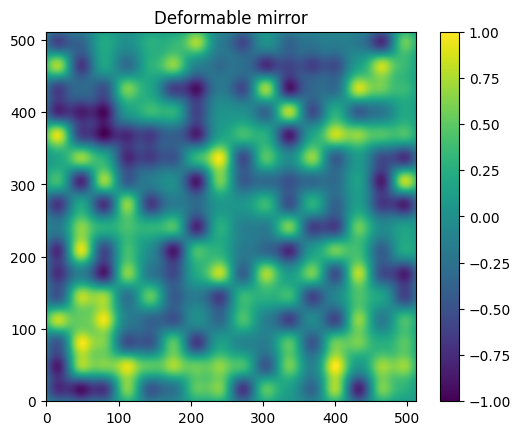

In [28]:
num_pix = 512
dist = 32
size = 13
bounds = 1

deform_mirror = create_DM(num_pix, dist, size, bounds)

plt.imshow(deform_mirror, origin="lower")
plt.colorbar()
plt.title("Deformable mirror")

In [34]:
def generate_test_set(num_vals, num_pix, dist, size, bounds):
    dataArray = np.zeros((num_vals, num_pix, num_pix), dtype=np.float32)
    for x in range(num_vals):
        dataArray[x] = create_DM(num_pix, dist, size, bounds)
    
    data_tensor = torch.from_numpy(dataArray)
    return data_tensor, dataArray

In [38]:
num_pix = 512
dist = 32
size = 13
bounds = 1
num_vals = 1000
data_tensor, dataArray = generate_test_set(num_vals, num_pix, dist, size, bounds)
print("Set generated")

Set generated


In [ ]:
train_set = TensorDataset(data_tensor) # needs checking

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 8)



In [ ]:
'''
Setting up loss function
'''

model = ResNet2(input_size = )

In [ ]:
'''
Training loop
'''

In [ ]:
'''
Validation set
'''